In [1]:
from IPython.display import display, HTML , Markdown
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import udf, col, pandas_udf
import snowflake.snowpark.types as T
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.datasets import make_blobs
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from numpy import random
import seaborn as sns
import pandas as pd
import numpy as np
import base64, json ,logging
from tqdm import tqdm
import sklearn.metrics
# Import the commonly defined utility scripts using
# dynamic path include
import sys
sys.path.append('../python/lutils')
import sflk_base as L

display(Markdown("### Initialization"))
logging.basicConfig(stream=sys.stdout, level=logging.ERROR)

# Source various helper functions
%run ./scripts/notebook_helpers.py

# Define the project home directory, this is used for locating the config.ini file
PROJECT_HOME_DIR = '../..'
config = L.get_config(PROJECT_HOME_DIR)
session = L.connect_to_snowflake(PROJECT_HOME_DIR)

if(session == None):
   raise Exception(f'Unable to connect to snowflake. Validate connection information ')

session.use_role(f'''{config['APP_DB']['role']}''')
session.use_schema(f'''{config['APP_DB']['database']}.{config['APP_DB']['schema']}''')
session.use_warehouse(f'''{config['SNOW_CONN']['warehouse']}''')

df1 = session.sql('select current_account(), current_user() ,current_role() ,current_database() ,current_schema();').to_pandas()
display(df1)

### Initialization

CURRENT_ACCOUNT() CURRENT_USER()         CURRENT_ROLE() CURRENT_DATABASE()  \
0          CIB92733         JPRUSA  SERVICESNOW_USER_ROLE            FASHION   

  CURRENT_SCHEMA()  
0           PUBLIC

# ML Modeling

We use snowflake containers to train our model, code can be found in /src/docker.

First we show the repository that will be storing the docker images

Then we define a bunch of relevant things that will be used later such as the image name, repository url, database, schema, repository, and username.

In [2]:
session.sql("CREATE OR REPLACE IMAGE REPOSITORY FASHION_REPOSITORY").collect()
pd.DataFrame(session.sql('show image repositories').collect())

created_on                name database_name  \
0 2023-09-11 11:29:40.914000-07:00  FASHION_REPOSITORY       FASHION   

  schema_name                                     repository_url  \
0      PUBLIC  sfsenorthamerica-polaris2.registry.snowflakeco...   

                   owner owner_role_type comment  
0  SERVICESNOW_USER_ROLE            ROLE

In [3]:
image_name = 'fashion:recommender'
repository_url = 'sfsenorthamerica-polaris2.registry.snowflakecomputing.com/fashion/public/fashion_repository'
db = 'fashion'
schema = 'public'
repo = 'fashion_repository'
user_name = 'jprusa'

## Create and Push Docker Image
0. open a terminal window and `cd` into `/src/docker`

1. Using the Docker CLI, execute the docker build command, specifying the current working directory (.):

    `docker build --rm --platform linux/amd64 -t <image_name> .`

2. Tag the image with the image URL:

    `docker tag <image_name> <repository_url>/<image_name>`

3. To authenticate Docker with the Snowflake registry, execute the docker login command:

    `docker login <repository_url> -u <user_name>`

4. To upload the image to the image repository, execute the following docker push command:

    `docker push <repository_url>/<image_name>`


In [4]:
print(f"docker build --rm --platform linux/amd64 -{image_name} .")
print(f"\ndocker tag {image_name} {repository_url}/{image_name}")
print(f"\ndocker login {repository_url} -u {user_name}")
print(f"\ndocker push {repository_url}/{image_name}")

docker build --rm --platform linux/amd64 -fashion:recommender .

docker tag fashion:recommender sfsenorthamerica-polaris2.registry.snowflakecomputing.com/fashion/public/fashion_repository/fashion:recommender

docker login sfsenorthamerica-polaris2.registry.snowflakecomputing.com/fashion/public/fashion_repository -u jprusa

docker push sfsenorthamerica-polaris2.registry.snowflakecomputing.com/fashion/public/fashion_repository/fashion:recommender


## Stage Specification file

We are now putting in the stage our specification file, which contains our docker image name, warehouse that we're planning on using, and our other arguments that we plan on passing in.

Then we check the @model_stg where we put our specification file to make sure that the specification file is actually there.

In [106]:
session.sql("""PUT file:///Users/jprusa/documents/github/Fashion/src/docker/fashion_recommender_spec.yaml 
@MODEL_STG AUTO_COMPRESS=FALSE OVERWRITE=TRUE;""").collect()

[Row(source='fashion_recommender_spec.yaml', target='fashion_recommender_spec.yaml', source_size=497, target_size=512, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

In [10]:
pd.DataFrame(session.sql('LIST @MODEL_STG').collect())

name    size  \
0            model_stg/fashion_recommender_spec.yaml     512   
1                         model_stg/optuna_model.sav  326928   
2                   model_stg/optuna_model_debug.sav  364928   
3  model_stg/udf_score_optuna_model_vec_cached/ud...    3456   

                                md5                  last_modified  
0  c40c69824a0e866a827e57b175f3ecf8   Wed, 2 Aug 2023 13:45:54 GMT  
1  6e6d651e85c41881296d40f538048181  Mon, 31 Jul 2023 16:06:48 GMT  
2  4ddee9af6d1c70e3e678d35d0b93e198   Tue, 1 Aug 2023 23:21:03 GMT  
3  14927735ea3142d68351f9cdff9030b9  Mon, 31 Jul 2023 16:08:38 GMT

## Data Prep
We split our data into train and test, for training and evaluation of the model purposes.

In [7]:
sdf = session.table('Final_Personalization_Full')
df_train, df_test = sdf.randomSplit([.8,.2])
df_train.write.save_as_table(table_name='CLICKSTREAM_TRAIN_FULL', mode='overwrite')
df_test.write.save_as_table(table_name='CLICKSTREAM_TEST_FULL', mode='overwrite')

## Training
### Create/Cleaning compute pool

The first cell is for "clean up." Run when finished with everything in order to not have to spend extra $ on resources unused.

The second cell is to specify compute resources such as max/min nodes, and the instance family we are using. In this case, no GPUs are being used.

In [3]:
session.sql("""ALTER COMPUTE POOL fashion_compute_pool STOP ALL;""").collect()
session.sql("""DROP COMPUTE POOL fashion_compute_pool;""").collect()

[Row(status='FASHION_COMPUTE_POOL successfully dropped.')]

In [95]:
session.sql("""CREATE OR REPLACE COMPUTE POOL fashion_compute_pool
  MIN_NODES = 1
  MAX_NODES = 1
  INSTANCE_FAMILY = STANDARD_5;""").collect()

[Row(status='Compute Pool FASHION_COMPUTE_POOL successfully created.')]

### Launch Training Job
This next cell launches the training job that does the model training. Below are statistics on how long it took us to train our model on the full data, and on roughly 1% of the data.

#### full data
- Roughly 4 hours to train 
- Compute Pool
    - 1 node 
    - standard 5

#### 1% data
- Roughly 3 minutes to train
- Compute Pool
    - 1 node
    - standard 5

In [107]:
output = session.sql("""EXECUTE SERVICE
  IN COMPUTE POOL fashion_compute_pool
  FROM @MODEL_STG
  SPEC='fashion_recommender_spec.yaml';""").collect()
UUID = output[0][0].split()[-1][:-1]

### Check Status and Logs

This is how you check the status and logs in order to check the progress of your model running.
- First cell gets the job status
- Second cell gets the logs for debugging errors, and model training progress purposes

In [109]:
session.sql(f"SELECT SYSTEM$GET_JOB_STATUS('{UUID}');").collect()

[Row(SYSTEM$GET_JOB_STATUS('01AE0A95-0001-B708-0022-6D870055C282')='[{"status":"READY","message":"Running","containerName":"fashion","instanceId":"0","serviceName":"JOB_01AE0A950001B70800226D870055C282","image":"sfsenorthamerica-polaris2.registry.snowflakecomputing.com/fashion/public/fashion_repository/fashion:recommender2","restartCount":0}]')]

In [114]:
print(session.sql(f"SELECT SYSTEM$GET_JOB_LOGS('{UUID}', 'fashion');").collect()[0][0])

job-tutorial - INFO - Job started
job-tutorial - INFO - Connection succeeded. Current session context: database="FASHION", schema="PUBLIC", warehouse="SNOWOPT_WH", role="SERVICESNOW_USER_ROLE"
job-tutorial - INFO - loading data from CLICKSTREAM_TRAIN_FULL. RAM memory % used: 2.4
job-tutorial - INFO - loaded 3539254 rows of training data. RAM memory % used: 6.7
job-tutorial - INFO - 	Extracting Embeddings. RAM memory % used: 6.8
job-tutorial - INFO - 	Converting Embeddings to pd.DataFrame. RAM memory % used: 28.9
job-tutorial - INFO - 	Concating Embeddings. RAM memory % used: 28.9
job-tutorial - INFO - 	RAM memory % used: 39.8
job-tutorial - INFO - preprocessed data, 35393 rows will be used for HPO. RAM memory % used: 28.9
job-tutorial - INFO - Running HPO...
[I 2023-08-02 16:19:16,903] A new study created in memory with name: no-name-81a6b65e-6d1f-4551-b4ae-dc46a607bb69
[I 2023-08-02 16:22:34,328] Trial 0 finished with value: 0.9702411619459151 and parameters: {'classifier': 'XGBoost',

# Inference

We now want to perform inference on our test set to see how good our model performed.
- Check to make sure the model was saved into the @MODEL_STG area from the training job
- Define our feature columns, test columns, test table, and reading in test table
- type_helper: Function that returns the types of our feature columns
- Defining our UDF that reads in the model, does necessary transformations on the data, predicts the interaction score, and returns the interaction scores
- Then we put it all together and call the UDF on our test set
- We finally visualize our model performance on the test set by seeing the ROC curve.

In [115]:
pd.DataFrame(session.sql('LIST @MODEL_STG').collect())

name       size  \
0            model_stg/fashion_recommender_spec.yaml        512   
1                         model_stg/optuna_model.sav     326928   
2                   model_stg/optuna_model_debug.sav  144325024   
3  model_stg/udf_score_optuna_model_vec_cached/ud...       3456   

                                md5                  last_modified  
0  1ffe3c85c4be281f13f4cdfece42483b   Wed, 2 Aug 2023 15:49:11 GMT  
1  6e6d651e85c41881296d40f538048181  Mon, 31 Jul 2023 16:06:48 GMT  
2  c27a538749d4f5e8eac0965da8751f0e   Wed, 2 Aug 2023 19:49:01 GMT  
3  14927735ea3142d68351f9cdff9030b9  Mon, 31 Jul 2023 16:08:38 GMT

In [5]:
feature_cols = [
    'GENDER', 'AGE', 'PROFESSION', 'WORK_EXPERIENCE',
    'ANNUAL_INCOME', 'SPENDING_SCORE', 'FAMILY_SIZE',
    'EMBEDDINGS'
]

target_col = 'INTERACTION'
test_table = 'CLICKSTREAM_TEST_FULL'

sdf = session.table(f'{test_table}')

In [7]:
def type_helper(t):
    if 'str' in t:
        return str
    else:
        return float
[type_helper(t[1]) for t in sdf[feature_cols].dtypes]

[str, float, str, float, float, float, float, str]

In [8]:
from cachetools import cached

session.add_packages('xgboost', 'scikit-learn','pandas','joblib','cachetools')
session.add_import("@MODEL_STG/optuna_model_debug.sav")  

@cached(cache={})
def load_model() -> object:
    from joblib import load

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'optuna_model_debug.sav'
    model = load(import_dir+model_name)
    return model

def transform_data(df):
    df = df.set_axis(['GENDER', 'AGE', 'PROFESSION', 'WORK_EXPERIENCE',
       'ANNUAL_INCOME', 'SPENDING_SCORE', 'FAMILY_SIZE', 'EMBEDDINGS'], axis=1)

    embedding_array = np.stack(df.EMBEDDINGS.apply(lambda x: np.array(eval(x))))
    embeddings_only = pd.DataFrame(embedding_array, columns=['EMBEDDING_'+str(i)for i in range(512)])

    df = pd.concat([df.drop('EMBEDDINGS', axis=1), embeddings_only], axis=1)    
    df.GENDER = df.GENDER.apply(lambda x: x=='Female').astype(int)
    profession_columns = [
        'PROFESSION_ARTIST','PROFESSION_DOCTOR','PROFESSION_ENGINEER',
        'PROFESSION_ENTERTAINMENT','PROFESSION_EXECUTIVE','PROFESSION_HEALTHCARE',
        'PROFESSION_HOMEMAKER','PROFESSION_LAWYER','PROFESSION_MARKETING'
    ]
    for c in profession_columns:
        df[c] = (df.PROFESSION == c[11:]).astype(int)
    df = df.drop('PROFESSION', axis=1)
    return df
    

@pandas_udf(max_batch_size=10000, session=session)
def udf_score_optuna_model_vec_cached(df: T.PandasDataFrame[str, float, str, float, float, float, float, str]) -> T.PandasSeries[float]:
    model = load_model()
    df = transform_data(df)
    y_pred = model.predict_proba(df)
    weights = np.array([0,.05,0.075,0.875])
    scored_data = pd.Series((weights*y_pred).sum(axis=1))
    return scored_data


In [119]:
sdf = session.table('CLICKSTREAM_TEST_FULL')
scored_sdf = sdf.with_column('PREDICTION', udf_score_optuna_model_vec_cached(*feature_cols))
scored_sdf.write.save_as_table(table_name='CLICKSTREAM_TEST_FULL', mode='overwrite')

In [120]:
scored_sdf = session.table('CLICKSTREAM_TEST_FULL')
scored_df = scored_sdf.to_pandas()
y_pred = scored_df.PREDICTION
y_test = scored_df.INTERACTION == 3

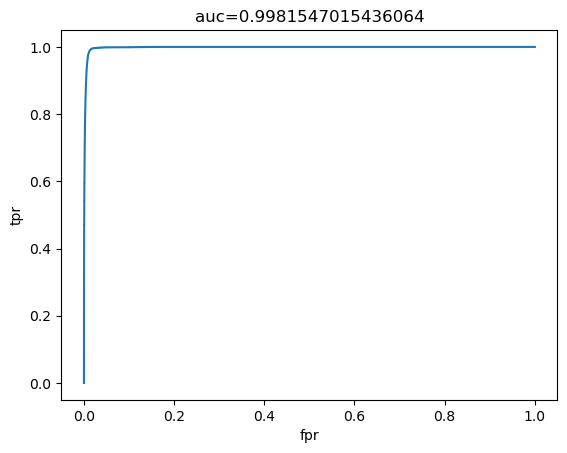

In [121]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred)
score = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr,tpr)
plt.title(f'auc={score}')
plt.xlabel('fpr')
plt.ylabel('tpr');

## All predictions
### Full Training Data

After we have tested our model in the test set to verify that the model actually performs well, we must then run our model through the whole entire dataset (all of our inventory) in order to get recommendations for each person, inventory combination.

WE first read in our images_encoded table,a nd final_personalization_full table, call on the UDF and save it as a new column labeled "PREDICTION" in our final_personalization_full table, and save the new table under clickstream_prediction_full. We then convert the table to pandas in order to get the customer profiles such as gender, age, and profession. 

We next generate scores for each item based on the specification that our SME have given us using a User Defined Function. This is not apart of the tutorial notebook but will serve later in the Streamlit/React UI. We then save the generated prices into the Clickstream_prediction_full table under the column "Price."

We then reuse the "get_image" and "visualize_model" functions. More information can be found in notebook #2.

Finally, we show examples of advanced personal recommendations for different unique profiles such as a 22 year old female homemaker or 33 year old male entertainer.feature_cols

In [9]:
sdf_ = session.table('IMAGES_ENCODED')
sdf = session.table('Final_Personalization_Full')
scored_sdf = sdf.with_column('PREDICTION', udf_score_optuna_model_vec_cached(*feature_cols))
scored_sdf.write.save_as_table(table_name='CLICKSTREAM_PREDICTION_FULL', mode='overwrite')
scored_df=scored_sdf.to_pandas()
customers = scored_df.groupby('CUSTOMERID').first()[['GENDER','AGE','PROFESSION']].copy()

In [10]:
pdf=scored_sdf.to_pandas()

In [11]:
#random price generator
def price_generator(item):
    if "shirt" in item:
        return random.randint(29,59)+round(random.random(),2)
    elif "pants" in item:
        return random.randint(49,79)+round(random.random(),2)
    elif "t_shirt" in item:
        return random.randint(39,49)+round(random.random(),2)
    else:
        return random.randint(29,79)+round(random.random(),2)
items=pdf.NAME.unique()
prices=[price_generator(item) for item in items]
item_price={k:v for k,v in zip(items, prices)}
pdf['PRICE']=[item_price.get(key) for key in pdf.NAME]

@pandas_udf(session=session)
def price(series: T.PandasSeries[str]) -> T.PandasSeries[float]:
    prices=[item_price.get(key) for key in series]
    return prices


In [12]:
feature_cols1=['NAME']
scored_sdf = scored_sdf.with_column('PRICE', price(*feature_cols1))
scored_sdf.write.save_as_table(table_name='CLICKSTREAM_PREDICTION_FULL', mode='overwrite')

In [13]:
data_table = "IMAGES_ENCODED"
data_col = 'DATA'
name_col = 'NAME'
label_col = 'LABEL'
embedding_col = "EMBEDDING"

def get_image(img_name):
    data = sdf_.filter(col(name_col) == img_name).select(label_col, data_col).to_pandas()
    img = Image.open(BytesIO(base64.b64decode(data[data_col][0])))
    label = data[label_col][0]
    return img, label

def visualize_model(item):
    fig = plt.figure()
    img, label = get_image(item)
    img = np.asarray(img)
    ax = plt.subplot()
    plt.imshow(img);

GENDER        Female
AGE               58
PROFESSION    Lawyer
Name: 872, dtype: object

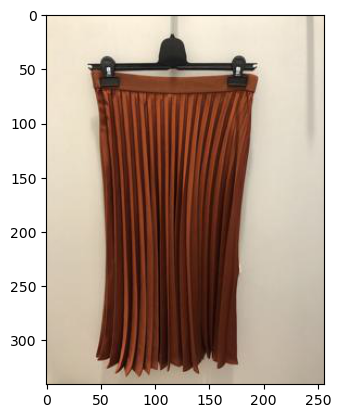

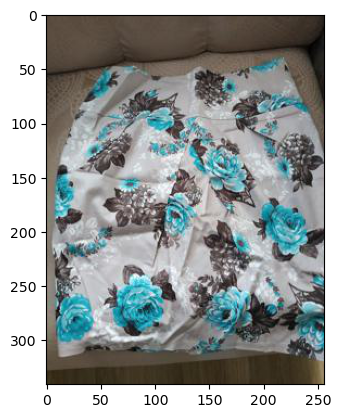

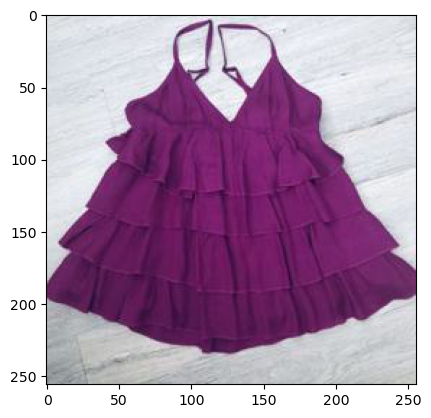

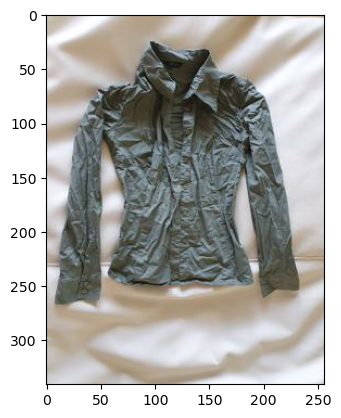

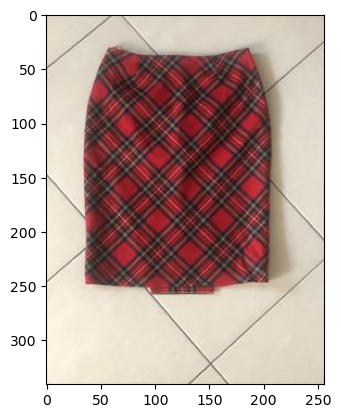

In [14]:
id = 872
display(customers.loc[id])
tmp = scored_df[(scored_df.CUSTOMERID == id)]
for i in tmp.sort_values('PREDICTION', ascending=False).NAME[:5]:
    visualize_model(i)

GENDER           Female
AGE                  22
PROFESSION    Homemaker
Name: 338, dtype: object

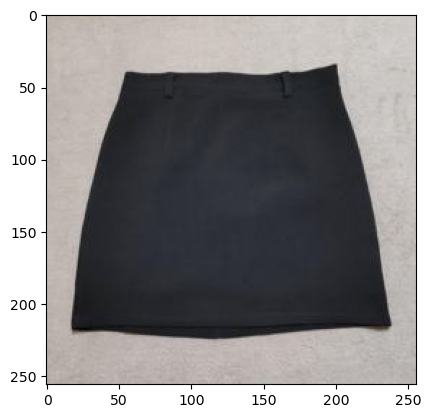

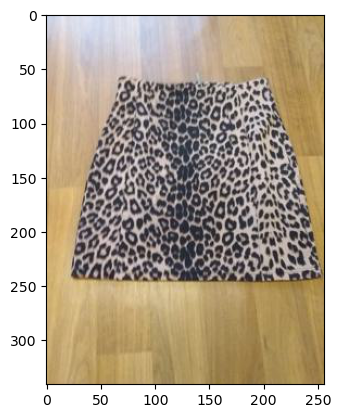

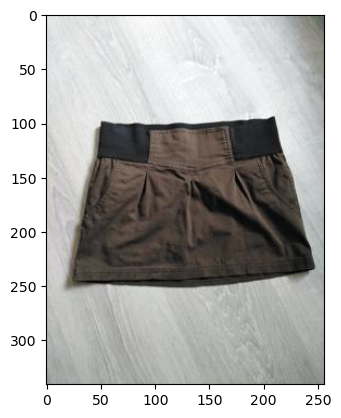

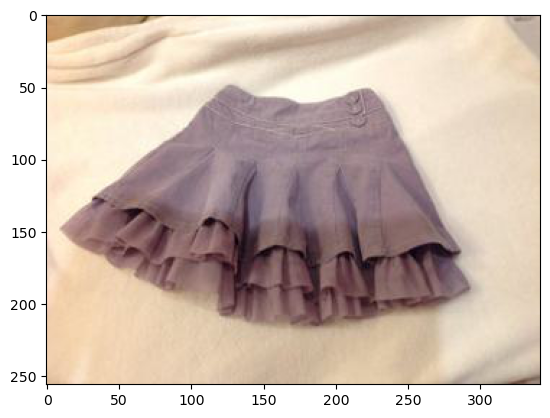

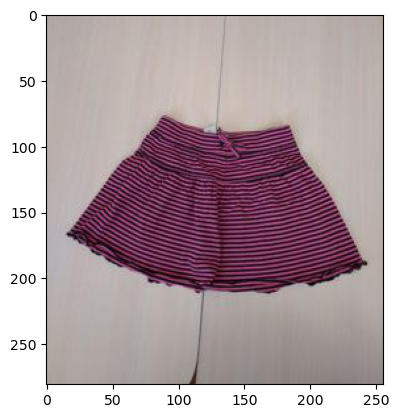

In [131]:
id = 338
display(customers.loc[id])
tmp = scored_df[(scored_df.CUSTOMERID == id)]
for i in tmp.sort_values('PREDICTION', ascending=False).NAME[:5]:
    visualize_model(i)

GENDER                 Male
AGE                      33
PROFESSION    Entertainment
Name: 103, dtype: object

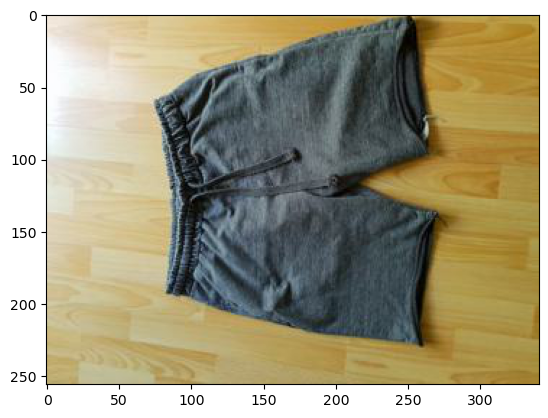

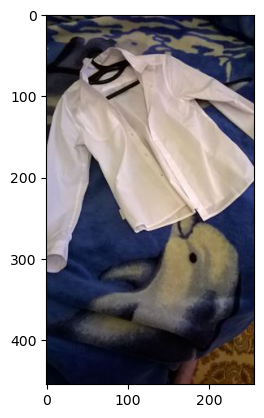

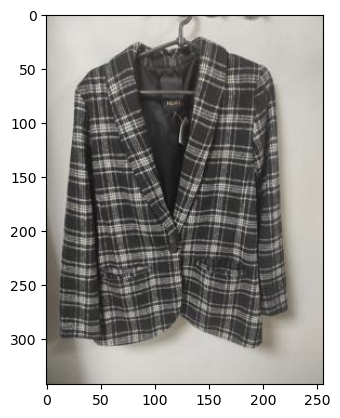

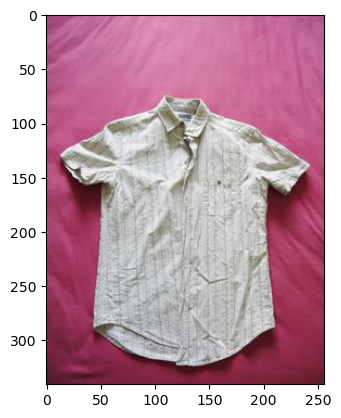

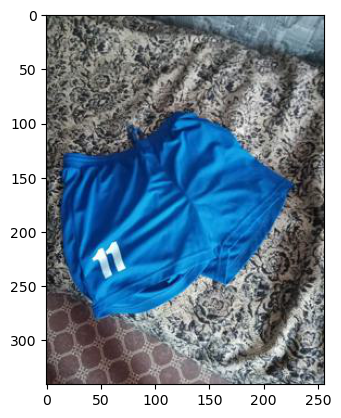

In [127]:
id = 103
display(customers.loc[id])
tmp = scored_df[(scored_df.CUSTOMERID == id)]
for i in tmp.sort_values('PREDICTION', ascending=False).NAME[:5]:
    visualize_model(i)

GENDER        Female
AGE               65
PROFESSION    Artist
Name: 416, dtype: object

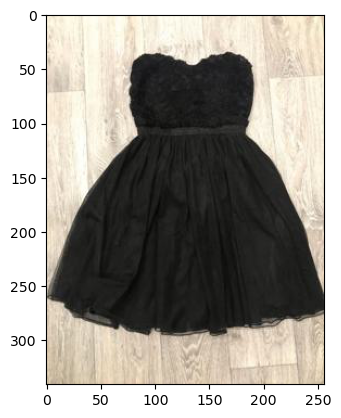

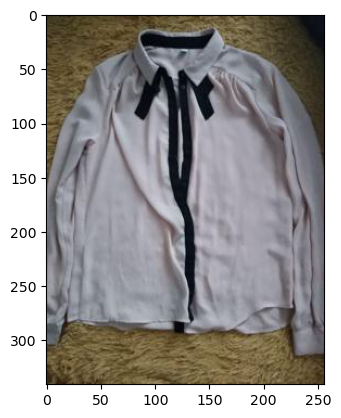

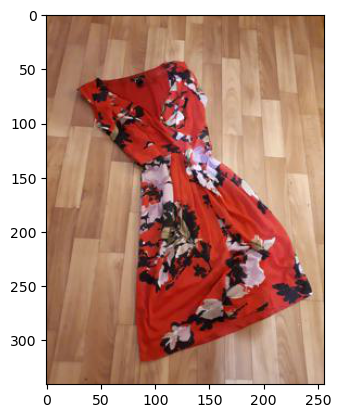

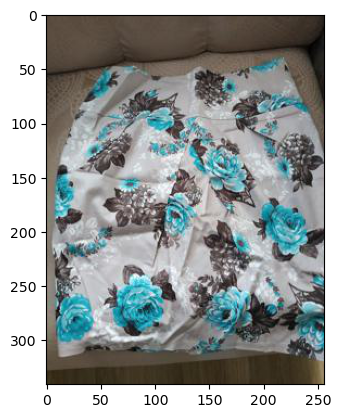

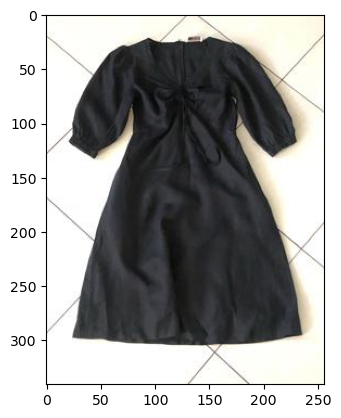

In [ ]:
id = 416
display(customers.loc[id])
tmp = scored_df[(scored_df.CUSTOMERID == id)]
for i in tmp.sort_values('PREDICTION', ascending=False).NAME[:5]:
    visualize_model(i)

GENDER            Female
AGE                   49
PROFESSION    Healthcare
Name: 10, dtype: object

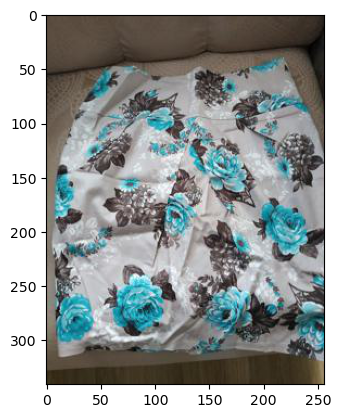

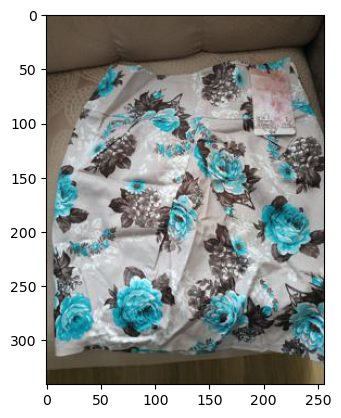

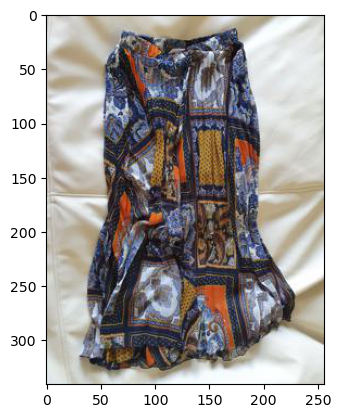

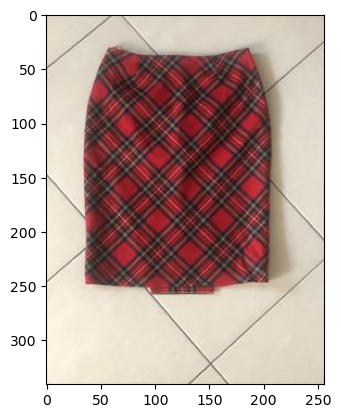

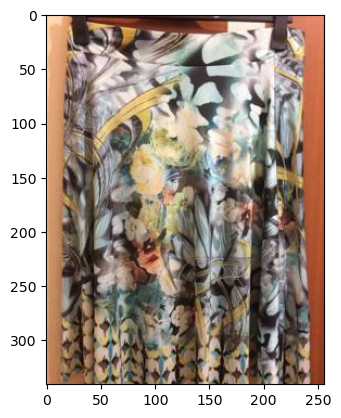

In [ ]:
category = 'skirt'
id = 10
display(customers.loc[id])
tmp = scored_df[(scored_df.CUSTOMERID == 10) & scored_df.NAME.str.contains(category)]
for i in tmp.sort_values('PREDICTION', ascending=False).NAME[:5]:
    visualize_model(i)